In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv, concat
sns.set_theme(context='notebook', style='white', font_scale=1.33)

import numpy as np
from os.path import dirname
from pandas import read_csv
import pandas as pd
from numba import njit
from tqdm import tqdm
import json

In [18]:
model=1
session=3

In [19]:
### Posterior predictive check.
np.random.seed(47404)

@njit
def inv_logit(x):
    return 1. / (1 + np.exp(-x))

def waic(log_lik):
    lppd = np.log( np.exp(log_lik).mean(axis=0) )
    pwaic = np.var(log_lik, axis=0)
    return lppd - pwaic





In [20]:
### load data
r = open(os.path.join('stan_data', f's{session}_data.json'))

# a dictionary
dd = json.load(r)

#reformat
R = np.array(dd['R'])
V = np.array(dd['V'])
Y = np.array(dd['Y'])
S = np.array(dd['S'])
N = dd['N']
E = dd['E']

# load dataframe
data = read_csv(os.path.join('stan_data',f's{session}_dataframe.csv'))

C = data.pivot_table('choice','exposure','stimulus').notnull().values.astype(int)
C = np.where(data.pivot_table('rt','exposure','stimulus',dropna=False).values < 0.2, 0, C)

## Load results.
StanFit = read_csv(os.path.join('stan_results', f'm{model}_s{session}.tsv.gz'), sep='\t', compression='gzip')
#StanFit = read_csv(os.path.join('stan_results', f'm{model}_s{session}.tsv'), sep='\t')

## Extract subject-level parameters.
beta = StanFit.filter(regex='^beta').values
# beta_P = StanFit.filter(regex='^beta_P').values
# beta_GO = StanFit.filter(regex='^beta_GO').values
eta = StanFit.filter(regex='^eta').values


## Parameter expansion
beta_vec = beta[:,S-1]
# beta_P_vec = beta_P[:,S-1]
# beta_GO_vec = beta_GO[:,S-1]
eta_vec = eta[:,S-1]


## init Q
Q1 = 0.5 * beta_vec
Q2 = 0.5 * beta_vec


In [21]:

## Preallocate space.
Y_pred = np.zeros((N, E)) 
Y_hat = np.zeros((N, E)) 
WAIC = np.zeros((N, E))

## Main loop.
for e in tqdm(range(E)):
    
    ## Define bias.
    bias = 0 #+ V[:,e] * beta_P_vec + beta_GO_vec
    
    ## Compute choice probability.
    theta = inv_logit( beta_vec*(Q1 - Q2 + bias))
    assert (theta<=1).all() and (theta>=0).all(), 'theta val issue'

    ## Define mask.
    mask = np.where(C[e], C[e], np.nan)
    
    ## Compute choice likelihood (stage 2).
    Y_pred[:,e] = np.where(Y[:,e], theta, 1-theta).mean(axis=0)*mask
    
    ## Compute WAIC (stage 2).
    WAIC[:,e] = waic(np.where(Y[:,e], np.log1p(theta), np.log1p(1-theta)))*mask
    
    ## Simulate choice (stage 2).
    y = np.random.binomial(1, theta)*mask
    Y_hat[:,e] = y.mean(axis=0)

    
    ## Update Q-values
    Q1 += Y[:,e] * eta_vec * ( R[:,e] - Q1 )
    Q2 += (1-Y[:,e]) * eta_vec * ( R[:,e] - Q2 )

100%|███████████████████████████████████████████████████████████████████████████████| 12/12 [01:30<00:00,  7.55s/it]


In [22]:
d_out = data[(data.rt.isna()) | (data.rt>=0.2)].copy()
d_out['Y_hat'] = Y_hat[~np.isnan(Y_hat)]
d_out['Y_pred'] = Y_pred[~np.isnan(Y_pred)]
d_out['waic'] = WAIC[~np.isnan(WAIC)]

## Restrict DataFrame to columns of interest.
cols = ['subject','session','block','trial','exposure','valence','action','robot',
        'correct','choice','rt','accuracy','sham','outcome','Y_hat','Y_pred','waic']
d_out = d_out[cols]

## Save.
f = os.path.join('stan_results', f'm{model}_s{session}_ppc.tsv')
d_out.to_csv(f, sep='\t', index=False)

In [27]:
stan_models = ['m1']#,'m2', 'm3']
sessions = [1,2,3]

all_data = []
for stan_model in stan_models:
    
    for session in sessions:

        df = read_csv(os.path.join('stan_results', f'{stan_model}_s{session}_ppc.tsv'), sep='\t')
        df['model'] = stan_model
        all_data.append(df)
        
all_data = concat(all_data)



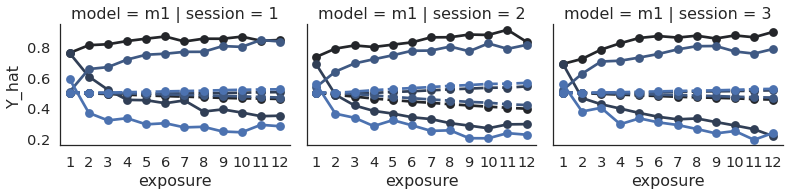

In [28]:
## Initialize d_out.
g = sns.FacetGrid(all_data, row='model', row_order=stan_models, col='session', col_order=sessions, aspect=1.25)
order = np.arange(12) + 1
hue_order = ['GW','NGW','GAL','NGAL']

g.map(sns.pointplot, 'exposure', 'choice', 'robot', order=order, hue_order=hue_order, ci=None)
g.map(sns.pointplot, 'exposure', 'Y_hat', 'robot', order=order, hue_order=hue_order, ci=None, linestyles='--')

In [30]:
agg = {'choice':'mean', 'Y_hat':'mean'}
gb = all_data.groupby(['model','session','subject','robot']).agg(agg).reset_index()



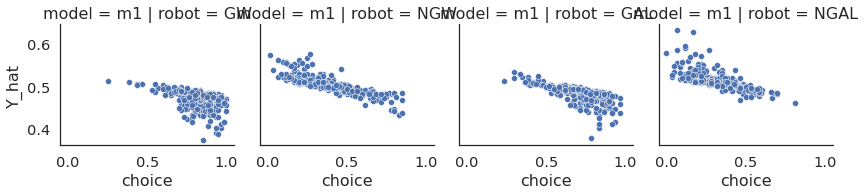

In [31]:
g = sns.FacetGrid(gb, row='model', row_order=stan_models, col='robot', col_order=['GW','NGW','GAL','NGAL'], )
g.map(sns.scatterplot, 'choice', 'Y_hat')


In [35]:
all_data.groupby(['model','session','subject']).waic.sum()

model  session  subject                 
m1     1        02lqpjp4pevk73p8f7ipewf9    95.425570
                09byk3dg92is9b06rwaybmoh    95.336154
                1ahxnduc1fr21fpplm87wkk6    95.647264
                1nn8ci654pmi5ny2ho1q3dxi    95.409361
                1x8zaa76pikfxwotrhhxcogi    93.399477
                                              ...    
       3        xvvfx6l6tl992j08612oxf20    80.715703
                y2g3nbh9r6arqdmk4elmwvgh    95.041321
                yl7dsryx5cewre22ixaoflv7    92.739912
                yy7cxf0b9a83n74z3fwgvlpv    95.711539
                zyflm7syc9jzpjpkv8k25xn3    94.135447
Name: waic, Length: 306, dtype: float64

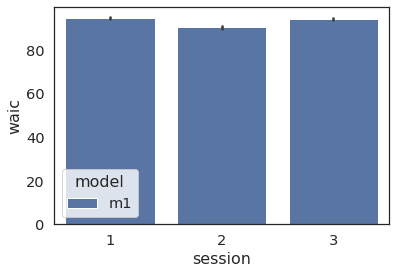

In [36]:
gb = all_data.groupby(['model','session','subject']).waic.sum().reset_index()

ax = sns.barplot(x='session', y='waic', hue='model', data=gb)
#ax.set(ylim=(-130,-100))


[(-130.0, -100.0)]

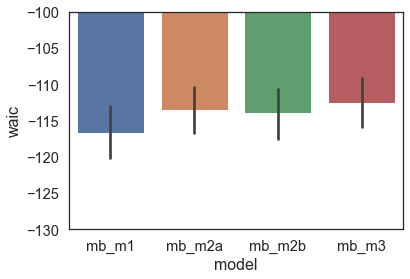

In [5]:
gb = data.groupby(['model','session','subject']).waic.sum().reset_index()

ax = sns.barplot(x='model', y='waic',data=gb)
ax.set(ylim=(-130,-100))